In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import wave

import warnings
warnings.filterwarnings('ignore')

---
---
# Lecture des signaux en .wav

In [2]:
def normalize(ys, amp=1.0):
    """Normalizes a wave array (ys) so the maximum amplitude is +amp or -amp.
    returns: wave array
    """
    high, low = abs(max(ys)), abs(min(ys))
    return amp * ys / max(high, low)


def open_wave(path):
    """Convert WAVE file to numpy 1D float array and sample frequency"""
    w = wave.open(path, 'rb')
    
    nchannels = w.getnchannels()
    nframes = w.getnframes()
    sampwidth = w.getsampwidth()
    framerate = w.getframerate()
    
    z_str = w.readframes(nframes)
    
    if nchannels != 1:
        raise Exception("Only mono WAVE files are supported.")
        
    dtype_map = {1:np.int8, 2:np.int16, 3:'special', 4:np.int32}
    if sampwidth not in dtype_map :
        raise ValueError('sampwidth %d unknown. Only 8, 16 or 32 bits WAVE files are supported.' % sampwidth)
        
    
    if sampwidth == 3:
        xs = np.fromstring(z_str, dtype=np.int8).astype(np.int32)
        ys = (xs[2::3] * 256 + xs[1::3]) * 256 + xs[0::3]
    else:
        ys = np.fromstring(z_str, dtype=dtype_map[sampwidth])

    Y = normalize(ys) 
    
    return Y, float(framerate)

---
## Signal émis par la source

In [3]:
### Signal d'entrée
signal1, fe = open_wave( 'input_signal.wav')
t1 = np.arange(0.,len(signal1)/fe, 1/fe)

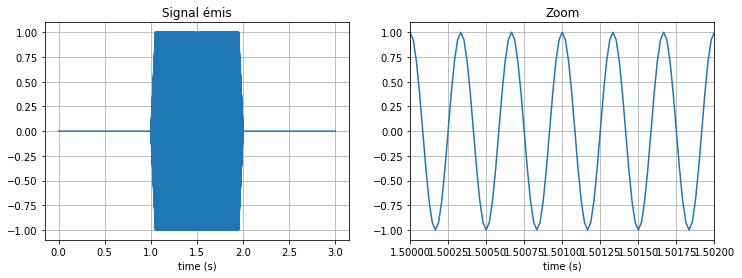

In [4]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(t1, signal1)
plt.xlabel('time (s)')
plt.title('Signal émis')
plt.grid()
plt.subplot(122)
plt.plot(t1, signal1)
plt.title('Zoom')
plt.xlabel('time (s)')
plt.grid()
plt.xlim([1.5,1.502])
plt.show()

In [5]:
### début de l'émission
t0 = t1[np.where(signal1 > 0.)[0][0]-1]
t0

1.0

---
## Signal reçu par l'hydrophone

In [6]:
### Signal reçu par l'hydrophone
signal2, fe2 = open_wave('received_S_noise.wav')
t2 = np.arange(0.,len(signal2)/fe2, 1/fe2)

In [7]:
#plt.figure(figsize=(12,4))
#plt.subplot(121)
#plt.plot(t2, signal2)
#plt.xlabel('time (s)')
#plt.title('Signal émis')
#plt.grid()

---
## Vérification des fréquences d'échantillonnage

In [8]:
if fe != fe2 : 
    print('Attention ! Les fréquences déchantillonnage ne sont pas les mêmes...')
else : 
    print("La fréquence d'échantillonnage est de %.1f kHz pour les 2 signaux." %(fe/1000.))

La fréquence d'échantillonnage est de 48.0 kHz pour les 2 signaux.


---
## Zero padding

In [9]:
def same_size (sig1, sig2) : 
    N1 = len(sig1)
    N2 = len(sig2)
    if N1 < N2 : 
        sig1 = np.hstack((sig1, np.zeros((N2 - N1))))
    elif N2 < N1 : 
        sig2 = np.hstack((sig2, np.zeros((N1 - N2))))
    return sig1, sig2    

In [10]:
sig1, sig2 = same_size (signal1, signal2)
t = np.arange(0., sig1.size/fe, 1/fe)

---
## Corrélation des signaux

In [11]:
def correl (sig1, sig2) : 
    sig1_fft = np.fft.fft(sig1)
    sig2_fft = np.fft.fft(sig2)
    conv = sig1_fft * sig2_fft
    S = np.abs(np.fft.ifft(conv))
    return S

In [12]:
S = correl (sig1, sig2)
S = normalize(S)

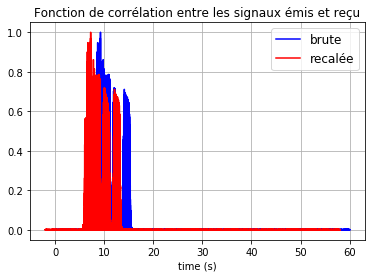

In [13]:
plt.plot(t, S, 'b', label='brute')
plt.plot(t-2*t0, S, 'r', label='recalée')
plt.grid()
plt.title('Fonction de corrélation entre les signaux émis et reçu')
plt.xlabel('time (s)')
plt.legend(fontsize=12)
plt.show()

In [14]:
seuil = 0.1
print('Le temps de parcours du signal est de %.5fs.' % (t[np.where(S > seuil)[0][0]]-2*t0))

Le temps de parcours du signal est de 5.97908s.


---
---
---
---
---
## Autocorrelation 

Same thing as convolution but with **one input reversed in time**. We throw away the negative lags. 

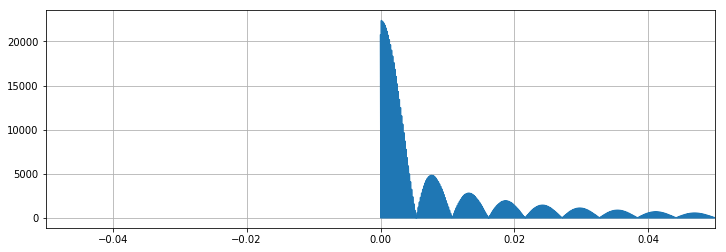

In [15]:
autoc = correl(sig1, sig1[::-1])
plt.figure(figsize=(12,4))
plt.plot(t, autoc)
plt.xlim(xmin=-0.05,xmax=0.05)
plt.grid()

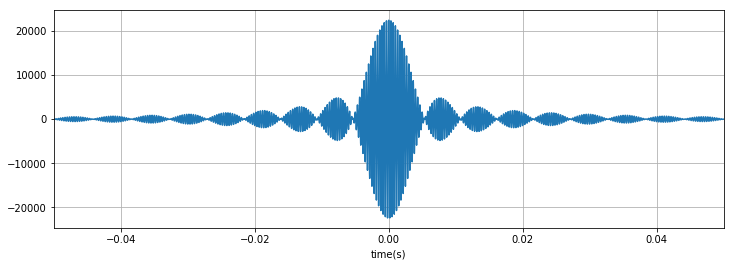

In [16]:
### 2eme méthode de scipy

from scipy.signal import fftconvolve
autoc = fftconvolve (sig1, sig1[::-1], mode='full')
#autoc = autoc[len(autoc)//2:]  # throw away negative lags. An other way is to np.roll(corr, corr.size//2).
tt = np.arange(-autoc.size/(2*fe),autoc.size/(2*fe), 1/fe)
plt.figure(figsize=(12,4))
plt.plot(tt, autoc)
plt.xlim(xmin=-0.05,xmax=0.05)
plt.xlabel('time(s)')
plt.grid()

In [17]:
#autoc2 = correl(sig2, sig2[::-1])
#plt.figure(figsize=(12,4))
#plt.plot(t, autoc2)
#plt.xlim(xmin=-0.01,xmax=0.1)
#plt.grid()